In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from IPython.display import display, HTML
from os import getcwd, path, chdir
import warnings
import string

# filter warnings(ONLY USE TEMPORARELY!)
warnings.filterwarnings("ignore")

# set paths
homedir = path.expanduser("~")
reppath = path.join(homedir,"Nextcloud","SESYN","_B09","Publications","3_SATPD2_AUDTUD","supplementary_files")
#reppath = path.join(homedir,"plandepth_aud_tud") # TODO: change to your individual path to the repository
datadir = path.join(reppath,"data")
fitdir  = path.join(datadir,"PosteriorSamples","2025-02-03_LPP_and_probDiscounting")

# import helper functions
chdir(reppath)
from helpers import mean_str

# load data
datafilepath = path.join(fitdir, "SAT_singleMiniblocks.csv")
df = pd.read_csv(datafilepath, dtype={'ID':object}, sep=";")
uniqueID_groups = df[(df.condition == "pooled") | (df.group2 == "SUD")].group.unique()

# scale conditions as binary indicators
df["steps"]=df["steps"] - df["steps"].min()

# add column for AUD and TUD categories
df.fillna(value={"scid_aud_sum":0,"scid_tud_sum":0,}, inplace=True)
sud_cats = np.array(["non","mild","moderate","severe"])
df["aud_cat"] = (df.scid_aud_sum // 2).clip(upper=3).astype("int")
df["aud_cat_label"] = sud_cats[ df["aud_cat"].values ]
df["tud_cat"] = (df.scid_tud_sum // 2).clip(upper=3).astype("int")
df["tud_cat_label"] = sud_cats[ df["tud_cat"].values ]

# add id for group2
df["group2_id"] = df.group2.str.contains("SUD").astype("int")

# create condition-wise df
df_noise = df.groupby(by=['ID','noise','steps', 'group',"group2","condition"], as_index=False).agg(mean_str)
df_noise.drop(columns=['block_num'], inplace=True)
df_noise['noise_label'] = df_noise.noise.replace({0:'low', 1:'high'})

# create subject-wise df
df_sbj = df.groupby(by=['ID','group',"group2","condition"], as_index=False).agg(mean_str)
df_sbj.drop(columns=['noise','steps','block_num'], inplace=True)

# set colors
sud_cat_palette = ['darkturquoise','xkcd:golden brown','xkcd:warm brown','xkcd:chocolate']
#group_palette = ['orange','green']
group_palette = ['darkturquoise','lightcoral','orange','mediumpurple']
group_palette_labels = ['Matched HC', 'AUD only', 'TUD only', 'AUD and TUD']
group_palette_pairs = [['darkturquoise','lightcoral'],
                       ['darkturquoise','orange'],
                       ['darkturquoise','mediumpurple']]
group_cmaps = ['Blues', 'Yellows', 'Reds', 'Purples']
#group_palette = "tab10"
groups = ['HC_match_all', 'AUD_only', 'TUD_only', 'AUD_and_TUD']
sud_groups = df[df.group2 == "SUD"].group.unique()

# set style of seaborn plots
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plot_alpha = 0.8
plt.rcParams.update({'axes.labelsize': 15,
                     'xtick.labelsize': 13,
                     'ytick.labelsize': 12})

# helper function for letter annotation for subplots
def letter_annot_axes(axs, size=16, posx=-0.1, posy=1.1):
    axs = axs.flat
    for n, ax in enumerate(axs):         
        ax.text(posx, posy, string.ascii_uppercase[n], transform=ax.transAxes, size=size, weight='bold')


## Participant Sample

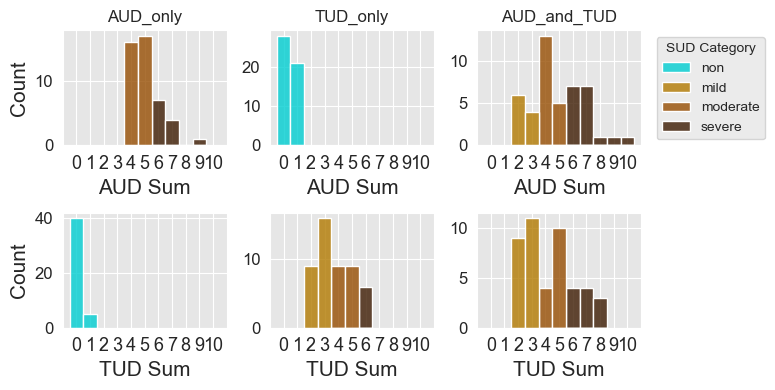

In [5]:
#%% plot historgram of SUD categories
fig, axes = plt.subplots(2, 3, figsize = (8,4), layout='constrained')

for i,s in enumerate(sud_groups):
    legend = True if i == 2 else False

    # top row of subplots
    g = sns.histplot(ax = axes[0,i], data=df_sbj[df_sbj.group == s], x='scid_aud_sum', hue='aud_cat_label', hue_order=sud_cats, 
                    discrete=True, palette=sud_cat_palette, legend=legend, alpha=plot_alpha);
    if i==2: sns.move_legend(axes[0,i], "upper right", bbox_to_anchor=(1.8, 1), title="SUD Category");
    axes[0,i].set_title(s)
    axes[0,i].set_xlabel("AUD Sum")
    axes[0,i].set_xlim(-1,11)
    axes[0,i].set_xticks(list(range(0,11)))
    
    # bottom row of subplots
    g = sns.histplot(ax = axes[1,i], data=df_sbj[df_sbj.group == s], x='scid_tud_sum', hue='tud_cat_label', hue_order=sud_cats, 
                    discrete=True, palette=sud_cat_palette, legend=False, alpha=plot_alpha);
    axes[1,i].set_xlabel("TUD Sum");
    axes[1,i].set_xlim(-1,11)
    axes[1,i].set_xticks(list(range(0,11)))
    
    # Clear y-axis labels for columns after the first
    [a.set_ylabel("") for a in axes[:,i] if i>0]

plt.tight_layout()
#plt.savefig("aud_sum_hist.png", dpi=300)

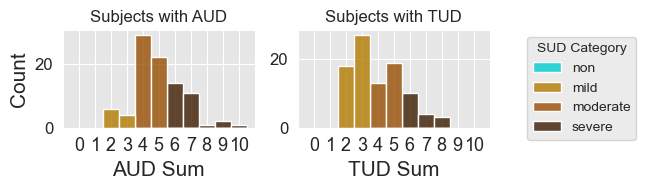

In [6]:
#%% plot historgram of SUD categories over all SUD subjects
fig, axes = plt.subplots(1, 2, figsize = (7,2), layout='constrained')

for i,s in enumerate(['aud','tud']):
    legend = True if i == 1 else False
    varlabel = "scid_" + s + "_sum"
    # top row of subplots
    g = sns.histplot(ax = axes[i], data=df_sbj[df_sbj[varlabel]>1], x=varlabel, hue=s + '_cat_label', hue_order=sud_cats, 
                    discrete=True, palette=sud_cat_palette, legend=legend, alpha=plot_alpha);
    if i==1: sns.move_legend(axes[i], "upper right", bbox_to_anchor=(1.8, 1), title="SUD Category");
    axes[i].set_title("Subjects with " + s.upper())
    axes[i].set_xlabel(s.upper()+" Sum")
    axes[i].set_xlim(-1,11)
    axes[i].set_xticks(list(range(0,11)))
       
# Clear y-axis labels for columns after the first
axes[1].set_ylabel("")

plt.tight_layout()
#plt.savefig("aud_sum_hist.png", dpi=300)

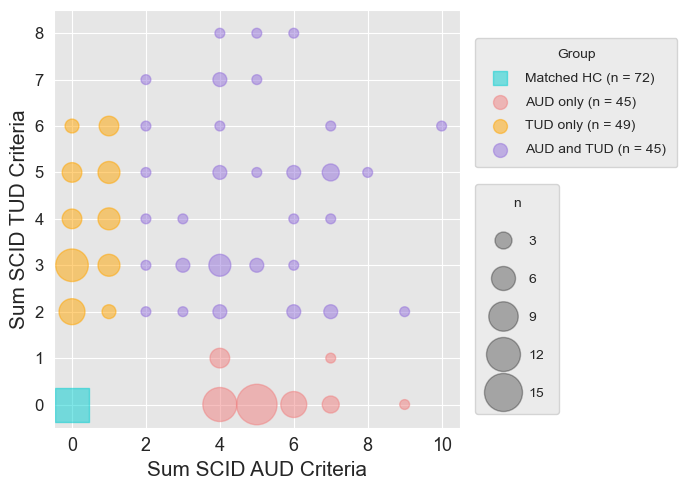

In [ ]:
# scatterplot of AUD and TUD criteria
fig, ax = plt.subplots(figsize=(7,5))

markersize_hc = 600
markersize_factor = 50 # factor for scaling markersize of SUD groups

for i, g in enumerate(groups):
    tmp = df_sbj[df_sbj.group==g].groupby(by=['scid_aud_sum','scid_tud_sum'], as_index=False).count().rename(columns={"ID":"nsubs"})
    nsubs = len(df_sbj[df_sbj.group==g])
    markersize = tmp.nsubs*markersize_factor
    ax.scatter(tmp.scid_aud_sum, tmp.scid_tud_sum, s=markersize, alpha=0.5, label=group_palette_labels[i]+' (n = '+str(nsubs)+')', color=group_palette[groups.index(g)]);

# snapshot first legend
handles1, labels1 = ax.get_legend_handles_labels()

# produce a second legend for markersizes of all scatters
tmp = df_sbj[df_sbj.group.isin(groups[1:])].groupby(by=['scid_aud_sum','scid_tud_sum'], as_index=False).count().rename(columns={"ID":"nsubs"})
markersize = tmp.nsubs*markersize_factor
marker_scatter = ax.scatter(tmp.scid_aud_sum, tmp.scid_tud_sum, s=markersize, alpha=0.3, color='grey');
handles2, labels2 = marker_scatter.legend_elements(prop="sizes", num=5, alpha=0.3, func=lambda s: s/markersize_factor)
legend2 = ax.legend(handles2, labels2, loc="upper left", bbox_to_anchor=(1.02, 0.6), borderpad=1, labelspacing=1.8,title="n")
# remove marker_scatter from plot
marker_scatter.remove()

# change HC scatter to square marker
handles1[0].set_visible(False)
handles1[0] = ax.scatter(0, 0, s=markersize_hc, alpha=0.5, color=group_palette[0], marker='s');

# adust sizes of legend handles
sizes=[]
# snapshot sizes of handles and set them to 100 for legend
for h in handles1:
    sizes.append(h.get_sizes())
    h.set_sizes([100])
legend1 = ax.legend(handles=handles1, labels=labels1, loc='upper left', bbox_to_anchor=(1.02, 0.95), borderpad=0.8, labelspacing=0.8, title="Group")
# reset sizes of handles
for i,h in enumerate(handles1):
    h.set_sizes(sizes[i])

ax.add_artist(legend2)


# adjust axis limits and labels
ax.set_xlabel('Sum SCID AUD Criteria');
ax.set_ylabel('Sum SCID TUD Criteria');
ax.set_xlim(-0.5,10.5)
ax.set_ylim(-0.5,8.5)

plt.tight_layout()
# #fig.savefig("Sample_AUD_TUD_Scatter_markersize.png", dpi=300)

## Inferred Model Parameters

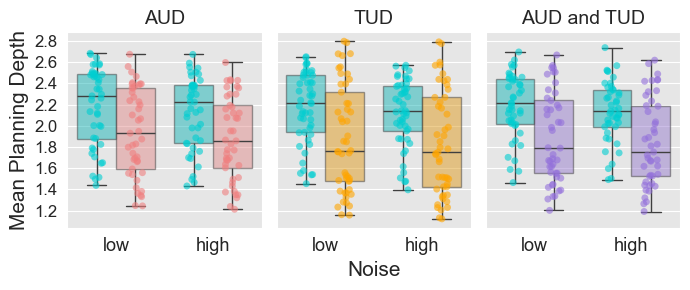

In [ ]:
#%% plot Mean Planning Depth for groups and noise condition
fig, axes = plt.subplots(1,3, sharey=True, figsize=(7,3))

plot_groups = ['AUD_only', 'TUD_only', 'AUD_and_TUD']
plot_groups_labels = ['AUD', 'TUD', 'AUD and TUD']
hue_order = ['matched_HC','SUD']
hue_labels = ['Matched HC','SUD']

for i in range(3):
    legend = False # if i<2 else True
    sns.boxplot(data=df_noise[df_noise.condition==plot_groups[i]], y="MeanPD", x="noise_label", hue='group2', hue_order=hue_order, ax=axes[i], palette=group_palette_pairs[i], boxprops={'alpha': 0.5}, legend=legend);
    sns.stripplot(  data=df_noise[df_noise.condition==plot_groups[i]], y="MeanPD", x="noise_label", hue='group2', hue_order=hue_order, ax=axes[i], palette=group_palette_pairs[i], dodge=True, legend=False, jitter=0.15, alpha=0.6);
    axes[i].set_title(plot_groups_labels[i], fontsize=14)
    axes[i].set_xlabel('Noise')
    if i!=1: axes[i].set_xlabel('')

axes[0].set_ylabel('Mean Planning Depth')
axes[0].set_yticks(np.arange(1.2,3,0.2))
#sns.move_legend(axes[-1], loc="center right", bbox_to_anchor=(1.8, 0.5), title = 'Group', labels = hue_labels)

#fig.suptitle('Mean Planning Depth and Noise Condition')
plt.tight_layout()
plt.show()

##fig.savefig("meanPD_noise.png", dpi=300)

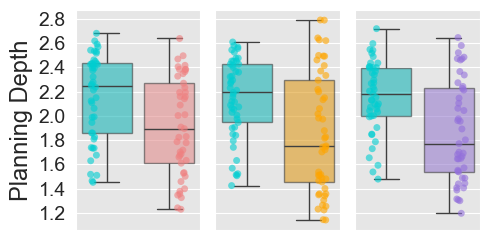

In [ ]:
#%% plot Mean Planning Depth for groups
fig, axes = plt.subplots(1,3, sharey=True, figsize=(5,2.5))

plot_groups = ['AUD_only', 'TUD_only', 'AUD_and_TUD']
plot_groups_labels = ['AUD', 'TUD', 'AUD and TUD']
xorder = ['matched_HC','SUD']
xlabels = [['Matched\nHC','AUD'],
           ['Matched\nHC','TUD'],
           ['Matched\nHC','AUD and\nTUD']]

for i in range(3):
    legend = False # if i<2 else True
    sns.boxplot(data=df_sbj[df_sbj.condition==plot_groups[i]], y="MeanPD", x="group2", order=xorder, ax=axes[i], palette=group_palette_pairs[i], boxprops={'alpha': 0.6}, legend=legend);
    sns.stripplot(  data=df_sbj[df_sbj.condition==plot_groups[i]], y="MeanPD", x="group2", order=xorder, ax=axes[i], palette=group_palette_pairs[i], dodge=True, legend=False, jitter=0.15, alpha=0.6);
    #axes[i].set_title(plot_groups_labels[i])
    axes[i].set_xlabel('')
    #axes[i].set_xticklabels(xlabels[i])
    axes[i].set_xticklabels([])

axes[0].set_ylabel('Planning Depth', fontsize=17)
axes[0].set_yticks(np.arange(1.2,3,0.2))
# set fontsize of y-ticks
for label in axes[0].get_yticklabels():
    label.set_fontsize(14)
#sns.move_legend(axes[-1], loc="center right", bbox_to_anchor=(1.8, 0.5), title = 'Group', labels = hue_labels)

#fig.suptitle('Mean Planning Depth and Noise Condition')
plt.tight_layout()
plt.show()

#fig.savefig("meanPD.png", dpi=300)

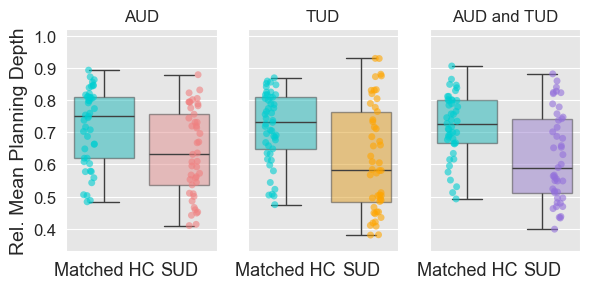

In [ ]:
#%% plot Mean Planning Depth for groups

# compute relative mean planning depth
df_sbj['relMeanPD'] = df_sbj.MeanPD / 3

fig, axes = plt.subplots(1,3, sharey=True, figsize=(6,3))

plot_groups = ['AUD_only', 'TUD_only', 'AUD_and_TUD']
plot_groups_labels = ['AUD', 'TUD', 'AUD and TUD']
xorder = ['matched_HC','SUD']
xlabels = ['Matched HC','SUD']

for i in range(3):
    legend = False # if i<2 else True
    sns.boxplot(data=df_sbj[df_sbj.condition==plot_groups[i]], y="relMeanPD", x="group2", order=xorder, ax=axes[i], palette=group_palette_pairs[i], boxprops={'alpha': 0.5}, legend=legend);
    sns.stripplot(  data=df_sbj[df_sbj.condition==plot_groups[i]], y="relMeanPD", x="group2", order=xorder, ax=axes[i], palette=group_palette_pairs[i], dodge=True, legend=False, jitter=0.15, alpha=0.6);
    axes[i].set_title(plot_groups_labels[i])
    axes[i].set_xlabel('')
    axes[i].set_xticklabels(xlabels)

axes[0].set_ylabel('Rel. Mean Planning Depth', fontsize=14)
axes[0].set_yticks(np.arange(.4,1.02,0.1))
axes[0].set_ylim(.33,1.02)
#sns.move_legend(axes[-1], loc="center right", bbox_to_anchor=(1.8, 0.5), title = 'Group', labels = hue_labels)

#fig.suptitle('Mean Planning Depth and Noise Condition')
plt.tight_layout()
plt.show()

##fig.savefig("rel_meanPD.png", dpi=300)

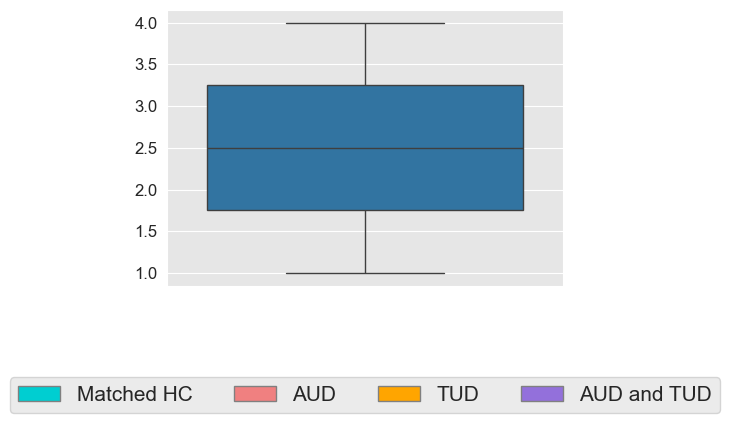

In [ ]:
#%% plot Mean Planning Depth for groups and noise condition WITH LEGEND!!
fig = plt.figure()

sns.boxplot([1,2,3,4])

# plot extra legend
handles = []
labels =  []

import matplotlib.patches as mpatches
# manually define a new patches for groups
labels = ['Matched HC', 'AUD', 'TUD', 'AUD and TUD']
for i,e in enumerate(labels):
    patch = mpatches.Patch(edgecolor='grey', facecolor=group_palette[i], label=e) 
    handles.append(patch) 
# plot the legend
plt.legend(handles=handles, loc='lower center', ncol=len(handles), bbox_to_anchor=[0.5,-0.5], fontsize=15)


#fig.suptitle('Mean Planning Depth and Noise Condition')
plt.tight_layout()
plt.show()

##fig.savefig("legend.png", dpi=300, bbox_inches = 'tight')

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,1.901933,0.090174,21.091724,9.552624e-36,0.317071,0.293248,1.722673,2.081194
1,SAT_RT,0.029410,0.008784,3.348198,1.208580e-03,0.317071,0.293248,0.011948,0.046872
2,group2_id,-0.155007,0.110526,-1.402446,1.643818e-01,0.317071,0.293248,-0.374725,0.064712
3,SAT_RT:group2_id,-0.007572,0.010266,-0.737599,4.627658e-01,0.317071,0.293248,-0.027981,0.012836


 n     r        CI95%  p-val      BF10  power
90 0.487 [0.31, 0.63]    0.0 1.494e+04  0.999


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,1.922150,0.092214,20.844344,5.130814e-37,0.41746,0.398868,1.739056,2.105244
1,SAT_RT,0.026940,0.009393,2.868021,5.099473e-03,0.41746,0.398868,0.008289,0.045590
2,group2_id,-0.577563,0.131175,-4.403010,2.822646e-05,0.41746,0.398868,-0.838013,-0.317113
3,SAT_RT:group2_id,0.041521,0.014159,2.932551,4.222453e-03,0.41746,0.398868,0.013409,0.069633


 n     r        CI95%  p-val      BF10  power
98 0.532 [0.37, 0.66]    0.0 7.927e+05    1.0


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,1.936538,0.085432,22.667650,4.950750e-38,0.427422,0.407448,1.766705,2.106371
1,SAT_RT,0.025923,0.008425,3.077070,2.803896e-03,0.427422,0.407448,0.009176,0.042671
2,group2_id,-0.413802,0.113509,-3.645557,4.560549e-04,0.427422,0.407448,-0.639449,-0.188154
3,SAT_RT:group2_id,0.023536,0.012048,1.953526,5.400811e-02,0.427422,0.407448,-0.000415,0.047487


 n     r       CI95%  p-val      BF10  power
90 0.561 [0.4, 0.69]    0.0 1.557e+06    1.0


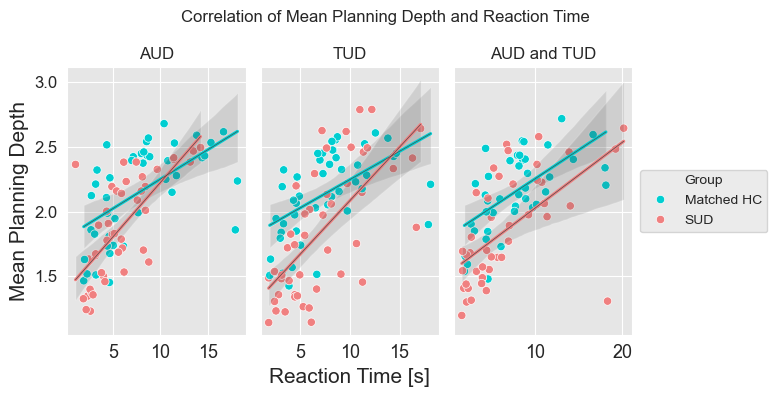

In [70]:
#%% plot Association of Mean Planning Depth and SAT RT
fig, axes = plt.subplots(1,3, sharey=True, figsize=(8,4))

plot_groups = ['AUD_only', 'TUD_only', 'AUD_and_TUD']
plot_groups_labels = ['AUD', 'TUD', 'AUD and TUD']
hue_order = ['matched_HC','SUD']
hue_labels = ['Matched HC','SUD']

for i in range(3):

    tmp = df_sbj[df_sbj.condition==plot_groups[i]]

    # remove outliers
    Q1_mhc  = tmp[tmp.group2 == hue_order[0]].SAT_RT.quantile(0.25)
    Q1_sud  = tmp[tmp.group2 == hue_order[1]].SAT_RT.quantile(0.25)
    Q3_mhc  = tmp[tmp.group2 == hue_order[0]].SAT_RT.quantile(0.75)
    Q3_sud  = tmp[tmp.group2 == hue_order[1]].SAT_RT.quantile(0.75)
    IQR_mhc = Q3_mhc - Q1_mhc
    IQR_sud = Q3_sud - Q1_sud
    lowers = [Q1_mhc - 1.5*IQR_mhc,
              Q1_sud - 1.5*IQR_sud] 
    uppers = [Q3_mhc + 1.5*IQR_mhc,
              Q3_sud + 1.5*IQR_sud] 
    tmp['lower'] = tmp.group2.replace({hue_order[0]:lowers[0],
                                       hue_order[1]:lowers[1]}) 
    tmp['upper'] = tmp.group2.replace({hue_order[0]:uppers[0],
                                       hue_order[1]:uppers[1]})

    legend = False if i<2 else True
    sns.scatterplot(data=tmp[(tmp.SAT_RT < tmp.upper) & (tmp.SAT_RT > tmp.lower)], y="MeanPD", x="SAT_RT", hue='group2', hue_order=hue_order, ax=axes[i], palette=group_palette, legend=legend);
    
    sns.regplot(data=tmp[(tmp.SAT_RT < tmp.upper) & (tmp.SAT_RT > tmp.lower) & (tmp.group2==hue_order[0])], y="MeanPD", x="SAT_RT", ax=axes[i], color="0.3", scatter=False, line_kws={"lw":1});
    sns.regplot(data=tmp[(tmp.SAT_RT < tmp.upper) & (tmp.SAT_RT > tmp.lower) & (tmp.group2==hue_order[1])], y="MeanPD", x="SAT_RT", ax=axes[i], color="0.3", scatter=False, line_kws={"lw":1});
    sns.regplot(data=tmp[(tmp.SAT_RT < tmp.upper) & (tmp.SAT_RT > tmp.lower) & (tmp.group2==hue_order[0])], y="MeanPD", x="SAT_RT", ax=axes[i], color=group_palette[0], scatter=False, ci=0);
    sns.regplot(data=tmp[(tmp.SAT_RT < tmp.upper) & (tmp.SAT_RT > tmp.lower) & (tmp.group2==hue_order[1])], y="MeanPD", x="SAT_RT", ax=axes[i], color=group_palette[1], scatter=False, ci=0);
    sns.regplot(data=tmp[(tmp.SAT_RT < tmp.upper) & (tmp.SAT_RT > tmp.lower) & (tmp.group2==hue_order[0])], y="MeanPD", x="SAT_RT", ax=axes[i], color="0.3", scatter=False, line_kws={"lw":0.5}, ci=0);
    sns.regplot(data=tmp[(tmp.SAT_RT < tmp.upper) & (tmp.SAT_RT > tmp.lower) & (tmp.group2==hue_order[1])], y="MeanPD", x="SAT_RT", ax=axes[i], color="0.3", scatter=False, line_kws={"lw":0.5}, ci=0);
    
    axes[i].set_title(plot_groups_labels[i])
    axes[i].set_xlabel('')
    
    # compute linear regression of MeanPD and predictors SAT_RT, group2 and interaction
    # add interaction term to the model
    tmp['SAT_RT:group2_id'] = tmp.SAT_RT * tmp.group2_id
    lm = pg.linear_regression(tmp[['SAT_RT','group2_id','SAT_RT:group2_id']], tmp.MeanPD)
    display(lm)
    print(pg.corr(tmp.SAT_RT, tmp.MeanPD, method='pearson').round(3).to_string(index=False))



axes[1].set_xlabel('Reaction Time [s]')
axes[0].set_ylabel('Mean Planning Depth')
sns.move_legend(axes[-1], loc="center right", bbox_to_anchor=(1.8, 0.5), title = 'Group', labels = hue_labels)

fig.suptitle('Correlation of Mean Planning Depth and Reaction Time')
plt.tight_layout()
plt.show()

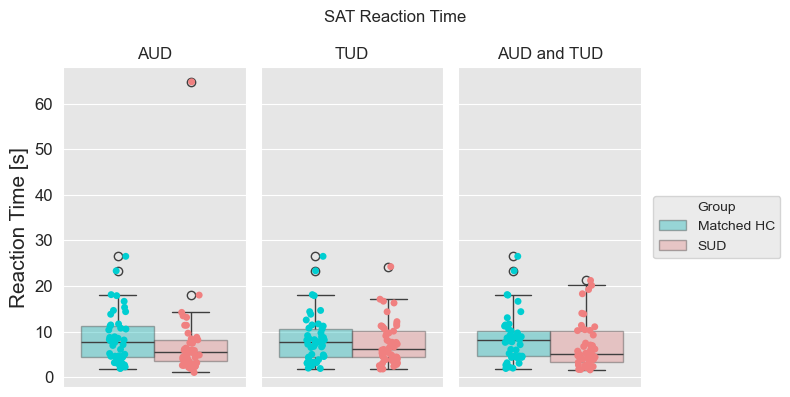

In [22]:
#%% plot SAT RT
fig, axes = plt.subplots(1,3, sharey=True, figsize=(8,4))

plot_groups = ['AUD_only', 'TUD_only', 'AUD_and_TUD']
plot_groups_labels = ['AUD', 'TUD', 'AUD and TUD']
hue_order = ['matched_HC','SUD']
hue_labels = ['Matched HC','SUD']

for i in range(3):

    tmp = df_sbj[df_sbj.condition==plot_groups[i]]
   
    legend = False if i<2 else True
    sns.boxplot(  data=tmp, y="SAT_RT", hue='group2', hue_order=hue_order, ax=axes[i], palette=group_palette, boxprops={'alpha': 0.4}, legend=legend);
    sns.stripplot(data=tmp, y="SAT_RT", hue='group2', hue_order=hue_order, ax=axes[i], palette=group_palette, dodge=True, legend=False);
    
    axes[i].set_title(plot_groups_labels[i])
    axes[i].set_xlabel('')

axes[0].set_ylabel('Reaction Time [s]')
sns.move_legend(axes[-1], loc="center right", bbox_to_anchor=(1.8, 0.5), title = 'Group', labels = hue_labels)

fig.suptitle('SAT Reaction Time')
plt.tight_layout()
plt.show()

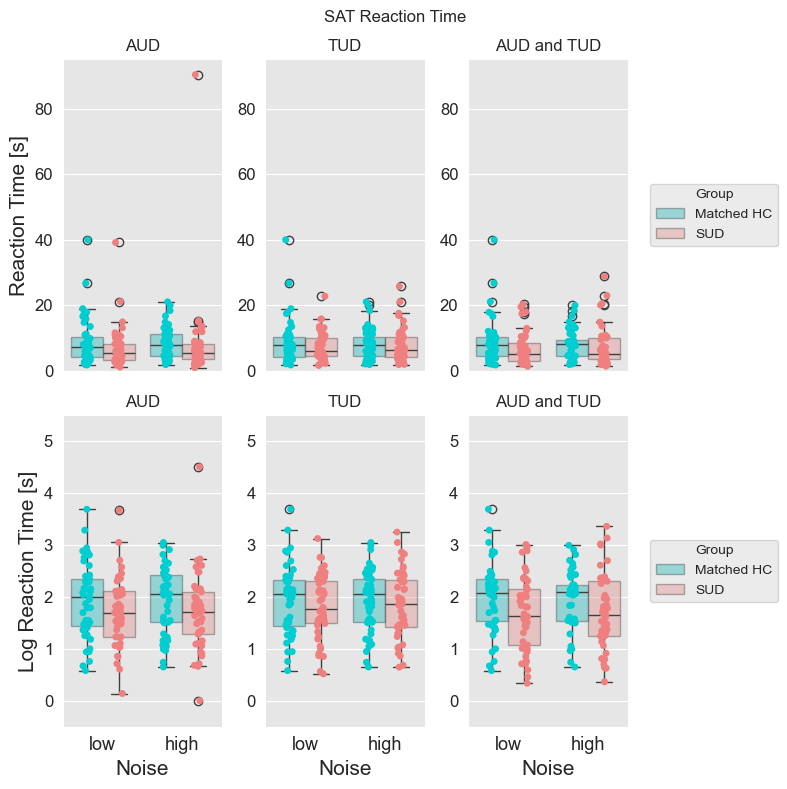

In [23]:
#%% plot SAT RT
fig, axes = plt.subplots(2,3, sharex=True, figsize=(8,8))

plot_groups = ['AUD_only', 'TUD_only', 'AUD_and_TUD']
plot_groups_labels = ['AUD', 'TUD', 'AUD and TUD']
hue_order = ['matched_HC','SUD']
hue_labels = ['Matched HC','SUD']

# add log-RT
df_noise['logSAT_RT'] = np.log(df_noise.SAT_RT)

ylabels = ['Reaction Time [s]', 'Log Reaction Time [s]']
ylims = [(0, 95), (-0.5, 5.5)]

for j,var in enumerate(['SAT_RT','logSAT_RT']):

    for i in range(3):

        tmp = df_noise[df_noise.condition==plot_groups[i]]
    
        legend = False if i<2 else True
        sns.boxplot(  data=tmp, y=var, x='noise', hue='group2', hue_order=hue_order, ax=axes[j,i], palette=group_palette, legend=legend, boxprops={'alpha': 0.4});
        sns.stripplot(data=tmp, y=var, x='noise', hue='group2', hue_order=hue_order, ax=axes[j,i], palette=group_palette, dodge=True, legend=False);
        
        axes[j,i].set_title(plot_groups_labels[i])
        axes[j,i].set_xticklabels(['low','high'])
        axes[j,i].set_xlabel('Noise')
        axes[j,i].set_ylabel('')
        axes[j,i].set_ylim(ylims[j])

    axes[j,0].set_ylabel(ylabels[j])
    sns.move_legend(axes[j,-1], loc="center left", bbox_to_anchor=(1.1, 0.5), title = 'Group', labels = hue_labels)

fig.suptitle('SAT Reaction Time')
plt.tight_layout()
plt.show()

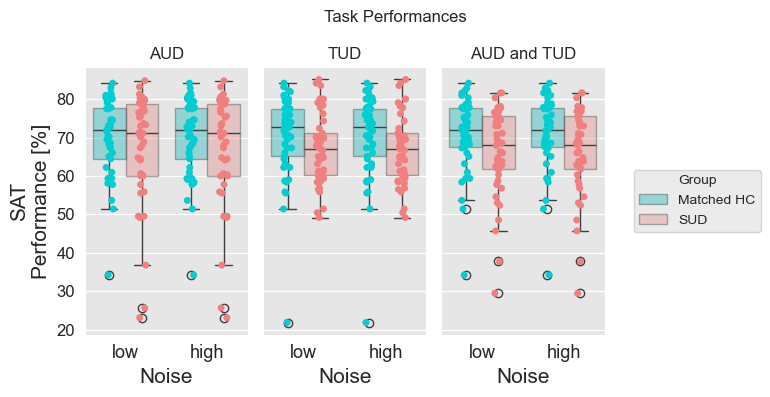

In [ ]:
#%% plot Performances for all tasks
fig, axes = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(8,4))

plot_groups = ['AUD_only', 'TUD_only', 'AUD_and_TUD']
plot_groups_labels = ['AUD', 'TUD', 'AUD and TUD']
hue_order = ['matched_HC','SUD']
hue_labels = ['Matched HC','SUD']

for i in range(3):
    legend = True if i==2 else False
    sns.boxplot(   data=df_noise[df_noise.condition==plot_groups[i]], y='SAT_PER', x='noise', hue='group2', hue_order=hue_order, ax=axes[i], palette=group_palette, boxprops={'alpha': 0.4}, legend=legend);
    sns.stripplot( data=df_noise[df_noise.condition==plot_groups[i]], y='SAT_PER', x='noise', hue='group2', hue_order=hue_order, ax=axes[i], palette=group_palette, dodge=True, legend=False);
    axes[i].set_title(plot_groups_labels[i])
    axes[i].set_xlabel('Noise')
    axes[i].set_xticklabels(['low','high'])
axes[0].set_ylabel('SAT\nPerformance [%]')

sns.move_legend(axes[2], loc="center right", bbox_to_anchor=(2, 0.5), title = 'Group', labels = hue_labels);

fig.suptitle('Task Performances')
plt.tight_layout();
plt.show();

##fig.savefig("performances_SATnoise.png", dpi=300)

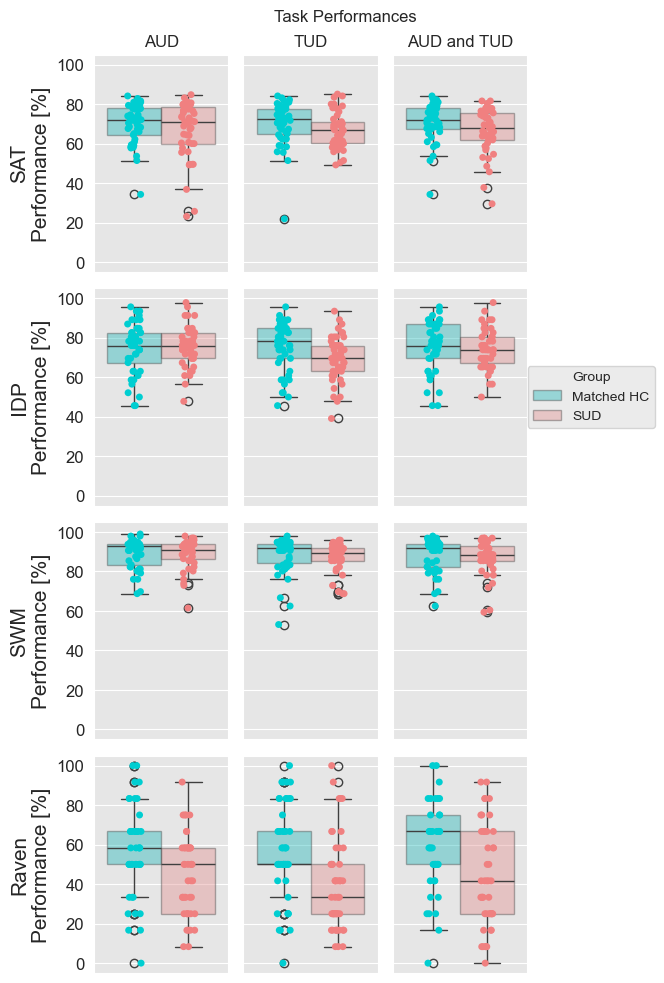

In [ ]:
#%% plot Performances for all tasks
fig, axes = plt.subplots(4,3, sharey=True, sharex=True, figsize=(7,10))

plot_groups = ['AUD_only', 'TUD_only', 'AUD_and_TUD']
plot_groups_labels = ['AUD', 'TUD', 'AUD and TUD']
hue_order = ['matched_HC','SUD']
hue_labels = ['Matched HC','SUD']
tasks = ['SAT_PER','IDP_PER','SWM_PER','RAV_PER']
tasks_labels = ['SAT','IDP','SWM','Raven']

for j in range(len(tasks)):
    for i in range(3):
        legend = True if (i==2 and j==1) else False
        sns.boxplot(data=df_sbj[df_sbj.condition==plot_groups[i]], y=tasks[j], hue='group2', hue_order=hue_order, ax=axes[j,i], palette=group_palette, boxprops={'alpha': 0.4}, legend=legend);
        sns.stripplot(  data=df_sbj[df_sbj.condition==plot_groups[i]], y=tasks[j], hue='group2', hue_order=hue_order, ax=axes[j,i], palette=group_palette, dodge=True, legend=False);
        if j==0: axes[j,i].set_title(plot_groups_labels[i])
        axes[j,i].set_xlabel('')
    axes[j,0].set_ylabel(tasks_labels[j] + '\nPerformance [%]')

sns.move_legend(axes[1,2], loc="center right", bbox_to_anchor=(2, 0.5), title = 'Group', labels = hue_labels);

fig.suptitle('Task Performances')
plt.tight_layout();
plt.show();

##fig.savefig("performances.png", dpi=300)

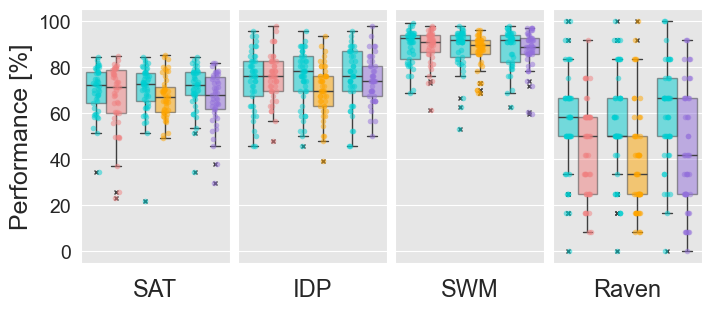

In [ ]:
#%% plot Performances for all tasks MERGED

fig, axes = plt.subplots(1,4, sharey=True, sharex=True, figsize=(7,3), layout="constrained")

plot_groups = ['AUD_only', 'TUD_only', 'AUD_and_TUD']
plot_groups_labels = ['\nAUD', '\nTUD', 'AUD\nand\nTUD']
hue_order = ['matched_HC','SUD']
hue_labels = ['Matched HC','SUD']
tasks = ['SAT_PER','IDP_PER','SWM_PER','RAV_PER']
tasks_labels = ['SAT','IDP','SWM','Raven']

for j in range(len(tasks)):
    legend = False #True if (i==2 and j==1) else False
    sns.boxplot(  data=df_sbj[df_sbj.condition.isin(plot_groups)], x='condition', y=tasks[j], order=plot_groups, hue='group2', hue_order=hue_order, ax=axes[j], palette=group_palette, boxprops={'alpha': 0.5}, legend=legend, flierprops={"marker": "x", "markersize": 3});
    sns.stripplot(data=df_sbj[df_sbj.condition.isin(plot_groups)], x='condition', y=tasks[j], order=plot_groups, hue='group2', hue_order=hue_order, ax=axes[j], palette=group_palette, dodge=True, legend=False, jitter=0.13, alpha=0.5, size=4);
    axes[j].set_xlabel(tasks_labels[j], fontsize=17)
    axes[j].set_xticklabels('') #plot_groups_labels)
    
    # set colors of group_palette
    for t in [[axes[j].patches,'F'],[axes[j].collections,'C']]:
        cols = np.array(group_palette_pairs).flatten(t[1])
        for p, c in zip(t[0], cols):
            p.set_facecolor(c)

# set size of x-ticks
for label in axes[0].get_yticklabels():
    label.set_fontsize(14)

axes[0].set_ylabel('Performance [%]', fontsize=18)

#sns.move_legend(axes[-1], loc="center right", bbox_to_anchor=(2, 0.5), title = 'Group', labels = hue_labels)

#fig.suptitle('Task Performances')
plt.show()

#fig.savefig("performances.png", dpi=300)

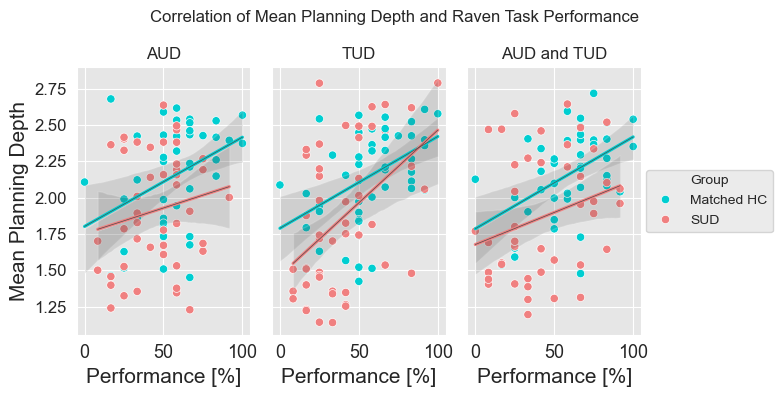

In [47]:
#%% plot Association of Mean Planning Depth and Raven Task Performance
fig, axes = plt.subplots(1,3, sharey=True, figsize=(8,4))

plot_groups = ['AUD_only', 'TUD_only', 'AUD_and_TUD']
plot_groups_labels = ['AUD', 'TUD', 'AUD and TUD']
hue_order = ['matched_HC','SUD']
hue_labels = ['Matched HC','SUD']

for i in range(3):
    legend = False if i<2 else True
    sns.scatterplot(data=df_sbj[df_sbj.condition==plot_groups[i]], y="MeanPD", x="RAV_PER", hue='group2', hue_order=hue_order, ax=axes[i], palette=group_palette, legend=legend);
    
    sns.regplot(data=df_sbj[(df_sbj.condition==plot_groups[i]) & (df_sbj.group2==hue_order[0])], y="MeanPD", x="RAV_PER", ax=axes[i], color="0.3", scatter=False, line_kws={"lw":1});
    sns.regplot(data=df_sbj[(df_sbj.condition==plot_groups[i]) & (df_sbj.group2==hue_order[1])], y="MeanPD", x="RAV_PER", ax=axes[i], color="0.3", scatter=False, line_kws={"lw":1});
    sns.regplot(data=df_sbj[(df_sbj.condition==plot_groups[i]) & (df_sbj.group2==hue_order[0])], y="MeanPD", x="RAV_PER", ax=axes[i], color=group_palette[0], scatter=False, ci=0);
    sns.regplot(data=df_sbj[(df_sbj.condition==plot_groups[i]) & (df_sbj.group2==hue_order[1])], y="MeanPD", x="RAV_PER", ax=axes[i], color=group_palette[1], scatter=False, ci=0);
    sns.regplot(data=df_sbj[(df_sbj.condition==plot_groups[i]) & (df_sbj.group2==hue_order[0])], y="MeanPD", x="RAV_PER", ax=axes[i], color="0.3", scatter=False, line_kws={"lw":0.5}, ci=0);
    sns.regplot(data=df_sbj[(df_sbj.condition==plot_groups[i]) & (df_sbj.group2==hue_order[1])], y="MeanPD", x="RAV_PER", ax=axes[i], color="0.3", scatter=False, line_kws={"lw":0.5}, ci=0);
    
    axes[i].set_title(plot_groups_labels[i])
    axes[i].set_xlabel('Performance [%]')

axes[0].set_ylabel('Mean Planning Depth')
sns.move_legend(axes[-1], loc="center right", bbox_to_anchor=(1.8, 0.5), title = 'Group', labels = hue_labels)

fig.suptitle('Correlation of Mean Planning Depth and Raven Task Performance')
plt.tight_layout()
plt.show()

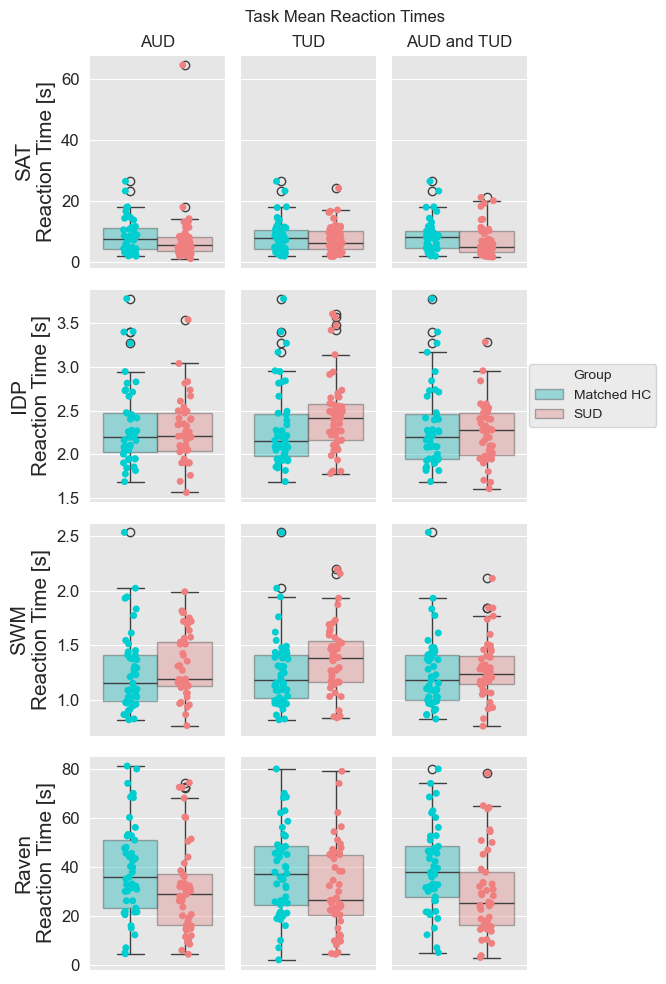

In [ ]:
#%% plot Reaction times for all tasks
fig, axes = plt.subplots(4,3, sharey='row', sharex=True, figsize=(7,10))

plot_groups = ['AUD_only', 'TUD_only', 'AUD_and_TUD']
plot_groups_labels = ['AUD', 'TUD', 'AUD and TUD']
hue_order = ['matched_HC','SUD']
hue_labels = ['Matched HC','SUD']
tasks = ['SAT_RT','IDP_RT','SWM_RT','RAV_RT']
tasks_labels = ['SAT','IDP','SWM','Raven']

for j in range(len(tasks)):
    for i in range(3):
        legend = True if (i==2 and j==1) else False
        sns.boxplot(data=df_sbj[df_sbj.condition==plot_groups[i]], y=tasks[j], hue='group2', hue_order=hue_order, ax=axes[j,i], palette=group_palette, boxprops={'alpha': 0.4}, legend=legend);
        sns.stripplot(  data=df_sbj[df_sbj.condition==plot_groups[i]], y=tasks[j], hue='group2', hue_order=hue_order, ax=axes[j,i], palette=group_palette, dodge=True, legend=False);
        if j==0: axes[j,i].set_title(plot_groups_labels[i])
        axes[j,i].set_xlabel('')
    axes[j,0].set_ylabel(tasks_labels[j] + '\nReaction Time [s]')

sns.move_legend(axes[1,2], loc="center right", bbox_to_anchor=(2, 0.5), title = 'Group', labels = hue_labels)

fig.suptitle('Task Mean Reaction Times')
plt.tight_layout()
plt.show()

##fig.savefig("reaction_times.png", dpi=300)

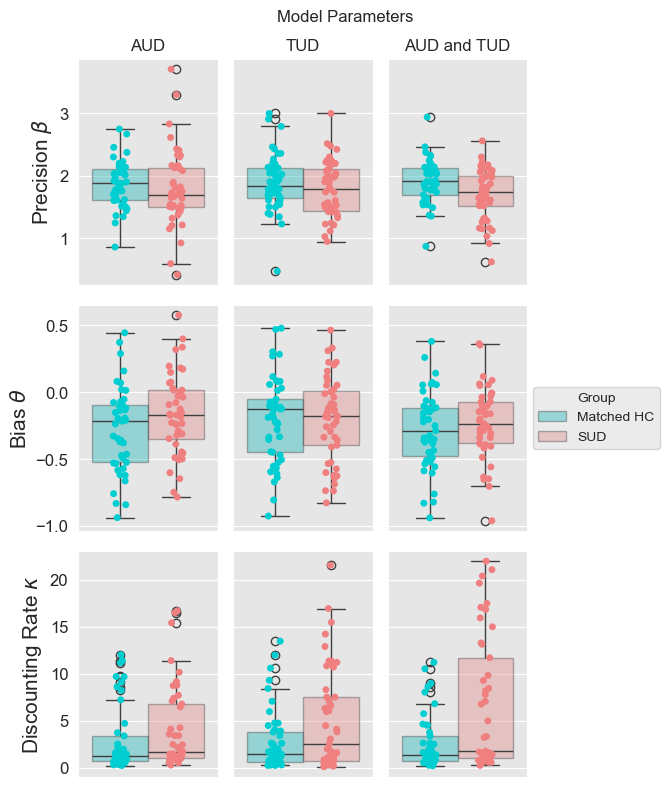

In [ ]:
#%% plot SAT model parameters

fig, axes = plt.subplots(3,3, sharey='row', sharex=True, figsize=(7,8));

plot_conditions = ['AUD_only', 'TUD_only', 'AUD_and_TUD']
plot_conditions_labels = ['AUD', 'TUD', 'AUD and TUD']
hue_order = ['matched_HC','SUD']
hue_labels = ['Matched HC','SUD']
params = ["model_beta","model_theta", "model_k"]
params_labels = [r'Precision $\beta$',r'Bias $\theta$',r'Discounting Rate $\kappa$']

for j in range(len(params)):
    for i in range(3):
        legend = True if (i==2 and j==1) else False
        sns.boxplot(data=df_sbj[df_sbj.condition==plot_conditions[i]], y=params[j], hue='group2', hue_order=hue_order, ax=axes[j,i], palette=group_palette, boxprops={'alpha': 0.4}, legend=legend);
        sns.stripplot(  data=df_sbj[df_sbj.condition==plot_conditions[i]], y=params[j], hue='group2', hue_order=hue_order, ax=axes[j,i], palette=group_palette, dodge=True, legend=False);
        if j==0: axes[j,i].set_title(plot_conditions_labels[i])
        axes[j,i].set_xlabel('')
    axes[j,0].set_ylabel(params_labels[j])

sns.move_legend(axes[1,2], loc="center right", bbox_to_anchor=(2, 0.5), title = 'Group', labels = hue_labels);

fig.suptitle('Model Parameters');
plt.tight_layout();
plt.show()

##fig.savefig("parameters.png", dpi=300)

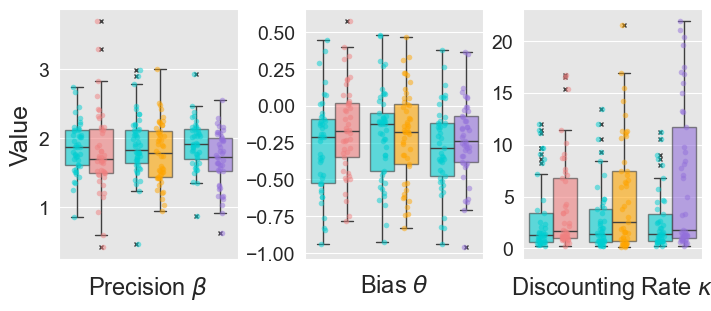

In [ ]:
#%% plot Model Parameters MERGED

fig, axes = plt.subplots(1,3, sharex=True, figsize=(7,3), layout="constrained")

plot_groups = ['AUD_only', 'TUD_only', 'AUD_and_TUD']
plot_groups_labels = ['\nAUD', '\nTUD', 'AUD\nand\nTUD']
hue_order = ['matched_HC','SUD']
hue_labels = ['Matched HC','SUD']
params = ["model_beta","model_theta", "model_k"]
params_labels = [r'Precision $\beta$',r'Bias $\theta$',r'Discounting Rate $\kappa$']

for j in range(len(params)):
    legend = False #True if (i==2 and j==1) else False
    sns.boxplot(  data=df_sbj[df_sbj.condition.isin(plot_groups)], x='condition', y=params[j], order=plot_groups, hue='group2', hue_order=hue_order, ax=axes[j], palette=group_palette, boxprops={'alpha': 0.6}, legend=legend, flierprops={"marker": "x", "markersize": 3});
    sns.stripplot(data=df_sbj[df_sbj.condition.isin(plot_groups)], x='condition', y=params[j], order=plot_groups, hue='group2', hue_order=hue_order, ax=axes[j], palette=group_palette, dodge=True, legend=False, jitter=0.13, alpha=0.5, size=4);
    axes[j].set_xlabel(params_labels[j], fontsize=17);
    axes[j].set_xticklabels(''); #plot_groups_labels)
    if j>0: axes[j].set_ylabel('');
    # set fontsize of y-ticks
    for label in axes[j].get_yticklabels():
        label.set_fontsize(14)
    
    # set colors of group_palette
    for t in [[axes[j].patches,'F'],[axes[j].collections,'C']]:
        cols = np.array(group_palette_pairs).flatten(t[1])
        for p, c in zip(t[0], cols):
            p.set_facecolor(c)

axes[0].set_ylabel('Value', fontsize=18);
#axes[1].set_yticks(np.arange(0.5,5,0.5));

#sns.move_legend(axes[-1], loc="center right", bbox_to_anchor=(2, 0.5), title = 'Group', labels = hue_labels)

#fig.suptitle('Task Performances')
#plt.tight_layout())
plt.show()

##fig.savefig("model_parameters.png", dpi=300)

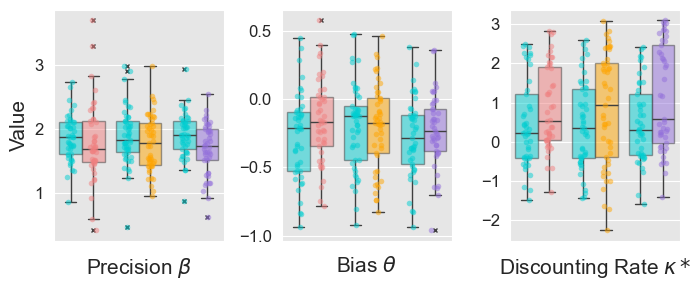

In [ ]:
#%% plot Model Parameters MERGED NORMALIZED KAPPA

fig, axes = plt.subplots(1,3, sharex=True, figsize=(7,3))

plot_groups = ['AUD_only', 'TUD_only', 'AUD_and_TUD']
plot_groups_labels = ['\nAUD', '\nTUD', 'AUD\nand\nTUD']
hue_order = ['matched_HC','SUD']
hue_labels = ['Matched HC','SUD']
params = ["model_beta","model_theta", "model_k_log"]
params_labels = [r'Precision $\beta$',r'Bias $\theta$',r'Discounting Rate $\kappa*$']

# create normalized model parameters
df_sbj['model_k_log'] = np.log(df_sbj['model_k'].values)

for j in range(len(params)):
    legend = False #True if (i==2 and j==1) else False
    sns.boxplot(  data=df_sbj[df_sbj.condition.isin(plot_groups)], x='condition', y=params[j], order=plot_groups, hue='group2', hue_order=hue_order, ax=axes[j], palette=group_palette, boxprops={'alpha': 0.5}, legend=legend, flierprops={"marker": "x", "markersize": 3});
    sns.stripplot(data=df_sbj[df_sbj.condition.isin(plot_groups)], x='condition', y=params[j], order=plot_groups, hue='group2', hue_order=hue_order, ax=axes[j], palette=group_palette, dodge=True, legend=False, jitter=0.13, alpha=0.5, size=4);
    axes[j].set_xlabel(params_labels[j]);
    axes[j].set_xticklabels(''); #plot_groups_labels)
    if j>0: axes[j].set_ylabel('');
    
    # set colors of group_palette
    for t in [[axes[j].patches,'F'],[axes[j].collections,'C']]:
        cols = np.array(group_palette_pairs).flatten(t[1])
        for p, c in zip(t[0], cols):
            p.set_facecolor(c)

axes[0].set_ylabel('Value');
#axes[1].set_yticks(np.arange(0.5,5,0.5));

#sns.move_legend(axes[-1], loc="center right", bbox_to_anchor=(2, 0.5), title = 'Group', labels = hue_labels)

#fig.suptitle('Task Performances')
plt.tight_layout()
plt.show()

##fig.savefig("model_parameters_normalized.png", dpi=300)

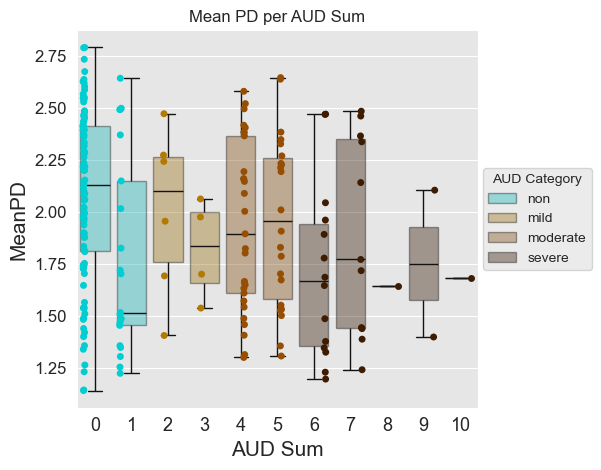

In [32]:
#%% plot Mean Planning Depth of AUD categories (pooled HC group is used)
fig, ax = plt.subplots()
plot_groups = ['HC_match_all', 'TUD_only', 'AUD_only', 'AUD_and_TUD']
xticks = list(range(int(df_sbj.scid_aud_sum.min()), int(df_sbj.scid_aud_sum.max())+1))
g = sns.boxplot(  data=df_sbj[df_sbj.group.isin(plot_groups)], y="MeanPD", x="scid_aud_sum", hue='aud_cat_label', ax=ax, boxprops={'alpha': 0.4}, palette=sud_cat_palette);
g = sns.stripplot(data=df_sbj[df_sbj.group.isin(plot_groups)], y="MeanPD", x="scid_aud_sum", hue='aud_cat_label', ax=ax, dodge=True, legend=False, palette=sud_cat_palette);
ax.set_title('Mean PD per AUD Sum')
ax.set_xticklabels(xticks)
sns.move_legend(ax,loc="center right",title="AUD Category", bbox_to_anchor=(1.3, 0.5));
ax.set_xlabel("AUD Sum");
plt.tight_layout()
plt.show()

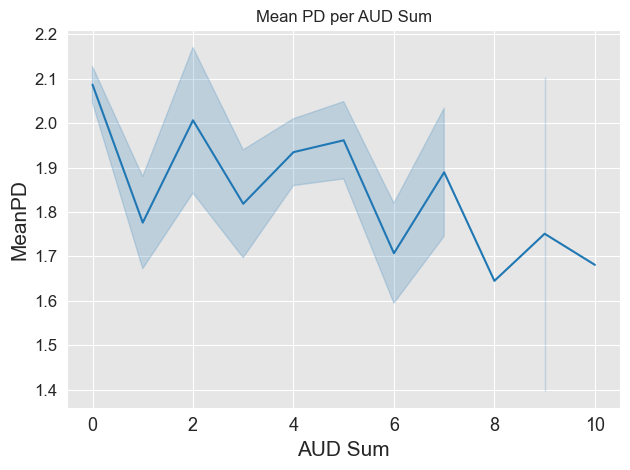

In [33]:
#%% plot Mean Planning Depth of AUD categories (pooled HC group is used)
fig, ax = plt.subplots()
plot_groups = ['HC_match_all', 'TUD_only', 'AUD_only', 'AUD_and_TUD']
g = sns.lineplot(  data=df_sbj[df_sbj.group.isin(plot_groups)], y="MeanPD", x="scid_aud_sum", ax=ax, errorbar='se');
ax.set_title('Mean PD per AUD Sum')
ax.set_xlabel("AUD Sum");
plt.tight_layout()
plt.show()

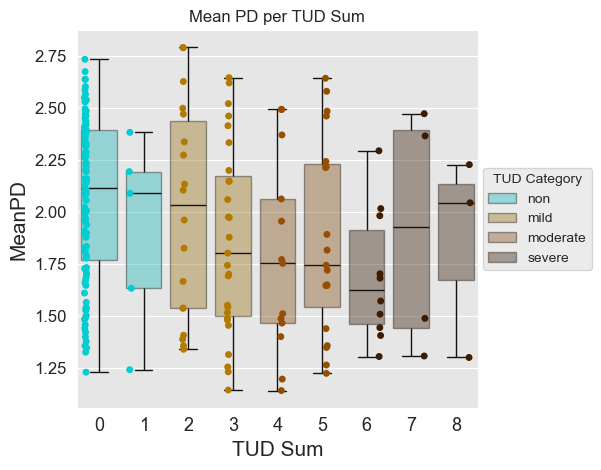

In [34]:
#%% plot Mean Planning Depth of TUD categories (pooled HC group is used)
fig, ax = plt.subplots()
plot_groups = ['HC_match_all', 'TUD_only', 'AUD_only', 'AUD_and_TUD']
xticks = list(range(int(df_sbj.scid_tud_sum.min()), int(df_sbj.scid_tud_sum.max())+1))
g = sns.boxplot(  data=df_sbj[df_sbj.group.isin(plot_groups)], y="MeanPD", x="scid_tud_sum", hue='tud_cat_label', ax=ax, boxprops={'alpha': 0.4}, palette=sud_cat_palette);
g = sns.stripplot(data=df_sbj[df_sbj.group.isin(plot_groups)], y="MeanPD", x="scid_tud_sum", hue='tud_cat_label', ax=ax, dodge=True, legend=False, palette=sud_cat_palette);
ax.set_title('Mean PD per TUD Sum')
ax.set_xticklabels(xticks)
sns.move_legend(ax,loc="center right",title="TUD Category", bbox_to_anchor=(1.3, 0.5));
ax.set_xlabel("TUD Sum");
plt.tight_layout()
plt.show()

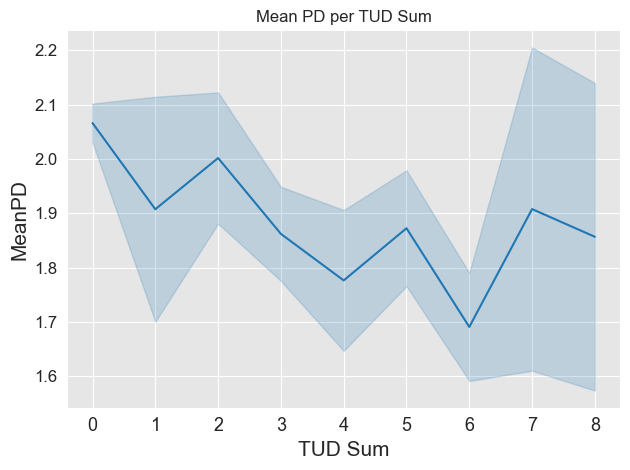

In [35]:
#%% plot Mean Planning Depth of TUD categories (pooled HC group is used)
fig, ax = plt.subplots()
plot_groups = ['HC_match_all', 'TUD_only', 'AUD_only', 'AUD_and_TUD']
g = sns.lineplot(  data=df_sbj[df_sbj.group.isin(plot_groups)], y="MeanPD", x="scid_tud_sum", ax=ax, errorbar='se');
ax.set_title('Mean PD per TUD Sum')
ax.set_xlabel("TUD Sum");
plt.tight_layout()
plt.show()

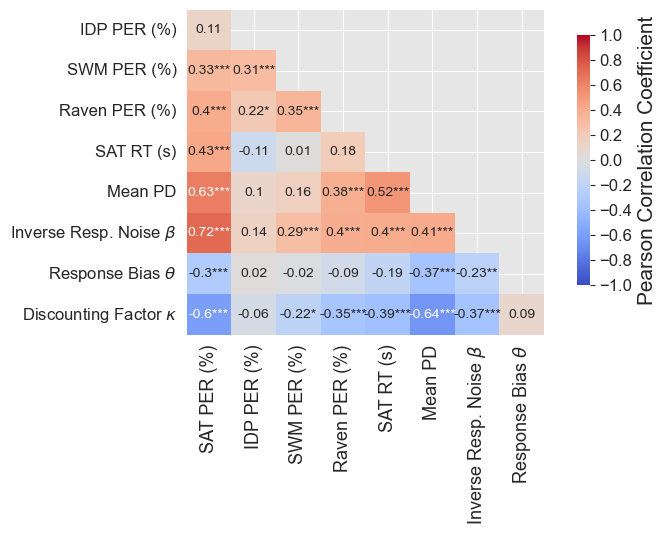

In [6]:
# overall correlation heatmap with bonferroni corrected p-values

from scipy.stats import pearsonr

corr_keys =   ['SAT_PER',     'IDP_PER',     'SWM_PER',     'RAV_PER',       'SAT_RT',     'MeanPD',   'model_beta',                  'model_theta'  ,           'model_k']
corr_labels = ['SAT PER (%)', 'IDP PER (%)', 'SWM PER (%)', 'Raven PER (%)', 'SAT RT (s)', 'Mean PD', r'Inverse Resp. Noise $\beta$', r'Response Bias $\theta$', r'Discounting Factor $\kappa$']


### get correlation and p-values

tmp = df_sbj[df_sbj.group.isin(groups)]
corr_mat = tmp[corr_keys].corr(numeric_only=True)
mask = np.triu(corr_mat) # get upper triangle of correlation matrix

def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer').reindex(df.columns)
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = pearsonr(tmp[r], tmp[c])[1]
    return pvalues

p_mat = calculate_pvalues(tmp[corr_keys])
p_mat = p_mat * len(corr_keys) # Bonferroni correction
sig_mat  = (p_mat < 0.05).astype(str).replace( {'True': '*', 'False': ''}) # significance matrix level 1
sig_mat2 = (p_mat < 0.01).astype(str).replace( {'True': '*', 'False': ''}) # significance matrix level 2
sig_mat3 = (p_mat < 0.001).astype(str).replace({'True': '*', 'False': ''}) # significance matrix level 3
sig_mat = sig_mat3 + sig_mat2 + sig_mat # significance matrix
annot_mat = corr_mat.round(2).astype(str) + sig_mat # annotation matrix

### plot

fig, ax = plt.subplots(figsize=(6.5, 5))
cbar_ax = fig.add_axes([0.85, .4, .02, .5])

# Plotting correlation heatmap
with sns.axes_style("white"):
    sns.heatmap(ax=ax, data=tmp[corr_keys].corr(numeric_only=True), cmap=sns.color_palette("coolwarm", as_cmap=True), annot=annot_mat, fmt='', vmin=-1, vmax=1, mask=mask, cbar_ax=cbar_ax, cbar_kws={'label': 'Pearson Correlation Coefficient'})

    ax.set_ylim(len(corr_keys), 1) 
    ax.set_yticklabels(corr_labels, rotation=0)
    ax.set_xlim(0, len(corr_keys)-1)
    ax.set_xticklabels(corr_labels, rotation=90) 
    cbar_ax.set_yticks(np.arange(-1, 1.1, 0.2))

    plt.subplots_adjust(wspace=0, top=0.95, bottom=0.3, left=0.25, right=0.8)
    plt.savefig("correlation_heatmap.png", dpi=300, bbox_inches='tight')